[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Applying a debiaser on climate projection data, based on AgERA5 reanalysis
This notebook shows how to apply a debiaser from the ibicus library on the CMIP6 climate projection data.

## Installing and importing necessary libraries

In order to run this notebook, the python environment has to be prepared by installing a number of additional libraries:
* `scitools-iris` - Loading and regridding data
* `ibicus`        - Debiasing data

In [ ]:
! pip install scitools-iris ibicus

In [197]:
from pathlib import Path   # Working with system paths and directories
import iris                # Reading and regridding data

# Working with data arrays:
import xarray as xr        
import numpy as np

import ibicus              # Debiasing

*Select the directory where climate data is stored (consistent with the `PARENT_PATH` of the `00 - Download and Preprocess Data.ipynb` notebook)*

In [234]:
PARENT_PATH = "./Data/agroclim_data" 

# Filename for combined historical projection data
COMBINED_HIST_MODEL_FILENAME = "combined_historical_model.nc"

# Filename for combined historical observation data
COMBINED_HIST_OBS_FILENAME = "combined_historical_obs.nc"

# Filename for combined future projection data
COMBINED_FUTURE_MODEL_FILENAME = "combined_future.nc"

# Filename for combined debiased future projecttion data
DEBIASED_FUTURE_FILENAME = "combined_future_debiased.nc"

We set up the data directory structure, based on the `00 - Download and Preprocess Data.ipynb` notebook, in order to refer to the data files downloaded there.

In [3]:
# Define the directory structure, starting at the parent path
parent_path = Path(PARENT_PATH)

# ---- HISTORICAL DATA DIRECTORIES ----
# ---- Historical model data ----
hist_model_path = parent_path / "historical_model_data"

# historical daily minimum near surface air temperature
hist_model_tmin_path = hist_model_path / "daily_minimum_near_surface_air_temperature_historical_ec_earth3_cc_extracted" / "tasmin_day_EC-Earth3-CC_historical_r1i1p1f1_gr_20000101-20131231.nc"

# historical daily mean near surface air temperature
hist_model_tmean_path = hist_model_path / "near_surface_air_temperature_historical_ec_earth3_cc_extracted" / "tas_day_EC-Earth3-CC_historical_r1i1p1f1_gr_20000101-20131231.nc"

# historical daily maximum near surface air temperature
hist_model_tmax_path = hist_model_path / "daily_maximum_near_surface_air_temperature_historical_ec_earth3_cc_extracted" / "tasmax_day_EC-Earth3-CC_historical_r1i1p1f1_gr_20000101-20131231.nc"

# historical precipitation flux
hist_model_prec_path = hist_model_path / "precipitation_historical_ec_earth3_cc_extracted" / "pr_day_EC-Earth3-CC_historical_r1i1p1f1_gr_20000101-20131231.nc"

# ---- Historical observation data ----
hist_obs_path = parent_path / "historical_observation_data"

# historical daily minimum near surface air temperature
hist_obs_tmin_path = hist_obs_path / "2m_temperature_24_hour_minimum_historical_obs_extracted"

# historical daily mean near surface air temperature
hist_obs_tmean_path = hist_obs_path / "2m_temperature_24_hour_mean_historical_obs_extracted"

# historical daily maximum near surface air temperature
hist_obs_tmax_path = hist_obs_path / "2m_temperature_24_hour_maximum_historical_obs_extracted"

# historical precipitation flux
hist_obs_prec_path = hist_obs_path / "precipitation_flux__historical_obs_extracted"


# ---- FUTURE PROJECTION DATA DIRECTORIES ----
future_model_path = parent_path / "future_model_data"

# future projection daily minimum near surface air temperature
future_model_tmin_path = future_model_path / "daily_minimum_near_surface_air_temperature_future_ec_earth3_cc_ssp5_8_5_extracted" / "tasmin_day_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20400101-20491231.nc"

# future projection daily mean near surface air temperature
future_model_tmean_path = future_model_path / "near_surface_air_temperature_future_ec_earth3_cc_ssp5_8_5_extracted" / "tas_day_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20400101-20491231.nc"

# future projection daily maximum near surface air temperature
future_model_tmax_path = future_model_path / "daily_maximum_near_surface_air_temperature_future_ec_earth3_cc_ssp5_8_5_extracted" / "tasmax_day_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20400101-20491231.nc"

# future projection precipitation flux
future_model_prec_path = future_model_path / "precipitation_future_ec_earth3_cc_ssp5_8_5_extracted" / "pr_day_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20400101-20491231.nc"

## 1. Convert and regrid data

Now that we have downloaded the data we need to make sure that observations and climate model data are:

- on the same temporal resolution: this is covered because we downloaded the data on daily resolution.
- on the same spatial resolution: we need to regrid the data.
- in the same units: we may need to convert units.

Furthermore we might want to extract additional information and need to get the numpy arrays corresponding to the data. In the numpy arrays we need to make sure that they have the form `[t,x,y]`.

### 1.1. Regrid data 

Now that we have data on the same temporal resolution for both the climate model and observations we need to make sure they are also on the same spatial one and regrid the datasets. The climate model data is on a coarser grid, therefore we will regrid the observational data onto this resolution. However there are also other solutions, where the [climate model data is regridded onto the resolution of the observations](https://esd.copernicus.org/articles/9/313/2018/).

We will use iris for the regridding, however there are also xarray solutions. Different variables might require different regridding schemes: [a list of ones available in iris is given here](https://scitools-iris.readthedocs.io/en/latest/userguide/interpolation_and_regridding.html?highlight=interpolate#regridding). In this case, we choose an area-weighted regridder.

In [236]:
# Load in CMIP6 datasets for grid reference

# --- Mean daily temperature ---
cm_hist_tmean = iris.load_cube(hist_model_tmean_path, "tas")
# Setting bounds is necessary for area-weighted regridding
cm_hist_tmean.coord('longitude').guess_bounds()
cm_hist_tmean.coord('latitude').guess_bounds()

cm_future_tmean = iris.load_cube(future_model_tmean_path, "tas")

# --- Minimum daily temperature ---
cm_hist_tmin = iris.load_cube(hist_model_tmin_path, "tasmin")
cm_hist_tmin.coord('longitude').guess_bounds()
cm_hist_tmin.coord('latitude').guess_bounds()

cm_future_tmin = iris.load_cube(future_model_tmin_path, "tasmin")

# --- Maximum daily temperature ---
cm_hist_tmax = iris.load_cube(hist_model_tmax_path, "tasmax")
cm_hist_tmax.coord('longitude').guess_bounds()
cm_hist_tmax.coord('latitude').guess_bounds()

cm_future_tmax = iris.load_cube(future_model_tmax_path, "tasmax")

# --- Daily precipitation ---
cm_hist_prec = iris.load_cube(hist_model_prec_path, "pr")
cm_hist_prec.coord('longitude').guess_bounds()
cm_hist_prec.coord('latitude').guess_bounds()

cm_future_prec = iris.load_cube(future_model_prec_path, "pr")

C:\Users\girza001\.conda\envs\agroclim\Lib\site-packages\iris\fileformats\cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
C:\Users\girza001\.conda\envs\agroclim\Lib\site-packages\iris\fileformats\cf.py:1475: IrisCfNonSpanningVarWarning: Ignoring variable lat_bnds referenced by variable lat: Dimensions ('time', 'lat', 'bnds') do not span ('lat',)
  warnings.warn(
C:\Users\girza001\.conda\envs\agroclim\Lib\site-packages\iris\fileformats\cf.py:1475: IrisCfNonSpanningVarWarning: Ignoring variable lon_bnds referenced by variable lon: Dimensions ('time', 'lon', 'bnds') do not span ('lon',)
  warnings.warn(
C:\Users\girza001\.conda\envs\agroclim\Lib\site-packages\iris\fileformats\cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tasmin'
  warnings.warn(
C:\Users\girza001\.conda\envs\agroclim\Lib\site-packages\iris\fileformats\cf.py:880: Iris

In [237]:
# Method used to unify a list of datacubes to prepare them for merging
def unify_cubes(cubes):
    iris.util.unify_time_units(cubes)
    for raw_cube in cubes:
        for attr in ['creation_date', 'tracking_id', 'history', 'CDI', 'CDO']:
                if attr in raw_cube.attributes:
                    del raw_cube.attributes[attr]

In [247]:
# Merge and regrid AgERA5 data
regrid_method = iris.analysis.AreaWeighted(mdtol=0.5)

# --- Mean daily temperature ---
obs_tmean_files = [file for file in hist_obs_tmean_path.iterdir()]
obs_tmean_cubes = iris.cube.CubeList([iris.load_cube(file) for file in obs_tmean_files])
unify_cubes(obs_tmean_cubes)
obs_tmean = obs_tmean_cubes.concatenate_cube() 
obs_tmean.coord('longitude').guess_bounds()
obs_tmean.coord('latitude').guess_bounds()

obs_tmean = obs_tmean.regrid(cm_hist_tmean, regrid_method)

# --- Minimum daily temperature ---
obs_tmin_files = [file for file in hist_obs_tmin_path.iterdir()]
obs_tmin_cubes = iris.cube.CubeList([iris.load_cube(file) for file in obs_tmin_files])
unify_cubes(obs_tmin_cubes)
obs_tmin = obs_tmin_cubes.concatenate_cube() 
obs_tmin.coord('longitude').guess_bounds()
obs_tmin.coord('latitude').guess_bounds()

obs_tmin = obs_tmin.regrid(cm_hist_tmin, regrid_method)

# --- Maximum daily temperature ---
obs_tmax_files = [file for file in hist_obs_tmax_path.iterdir()]
obs_tmax_cubes = iris.cube.CubeList([iris.load_cube(file) for file in obs_tmax_files])
unify_cubes(obs_tmax_cubes)
obs_tmax = obs_tmax_cubes.concatenate_cube() 
obs_tmax.coord('longitude').guess_bounds()
obs_tmax.coord('latitude').guess_bounds()

obs_tmax = obs_tmax.regrid(cm_hist_tmax, regrid_method)

# --- Daily precipitation ---
obs_prec_files = [file for file in hist_obs_prec_path.iterdir()]
obs_prec_cubes = iris.cube.CubeList([iris.load_cube(file) for file in obs_prec_files])
unify_cubes(obs_prec_cubes)
obs_prec = obs_prec_cubes.concatenate_cube() 
obs_prec.coord('longitude').guess_bounds()
obs_prec.coord('latitude').guess_bounds()

obs_prec = obs_prec.regrid(cm_hist_prec, regrid_method)

### 1.2. Extract additional information

The data objects are now all at the same temporal and spatial resolution. Because some debiasers need the dates as input, it is useful to extract them here:

In [239]:
def get_dates(x):
    time_dimension = x.coords()[0]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

get_dates = np.vectorize(get_dates)

In [240]:
dates_cm_hist_tmean = get_dates(cm_hist_tmean)
dates_cm_future_tmean = get_dates(cm_future_tmean)

dates_cm_hist_tmin = get_dates(cm_hist_tmin)
dates_cm_future_tmin = get_dates(cm_future_tmin)

dates_cm_hist_tmax = get_dates(cm_hist_tmax)
dates_cm_future_tmax = get_dates(cm_future_tmax)

dates_cm_hist_prec = get_dates(cm_hist_prec)
dates_cm_future_prec = get_dates(cm_future_prec)

dates_obs_tmean = get_dates(obs_tmean)
dates_obs_tmin = get_dates(obs_tmin)
dates_obs_tmax = get_dates(obs_tmax)
dates_obs_prec = get_dates(obs_prec)

C:\Users\girza001\.conda\envs\agroclim\Lib\site-packages\iris\common\mixin.py:203: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)


### 1.3 Save combined and regridded data

In [ ]:
# Duplicate existing dataset and fill in values
combined_hist_model = xr.open_mfdataset(hist_model_tmean_path)
combined_future_model = xr.open_mfdataset(future_model_tmean_path)
combined_hist_obs = xr.DataArray.from_iris(obs_tmean)

# Add the new variables to the dataset
combined_hist_model["tas"] = xr.DataArray.from_iris(cm_hist_tmean)
combined_hist_model["tasmin"] = xr.DataArray.from_iris(cm_hist_tmin)
combined_hist_model["tasmax"] = xr.DataArray.from_iris(cm_hist_tmax)
combined_hist_model["pr"] = xr.DataArray.from_iris(cm_hist_prec)

combined_future_model["tas"] = xr.DataArray.from_iris(cm_future_tmean)
combined_future_model["tasmin"] = xr.DataArray.from_iris(cm_future_tmin)
combined_future_model["tasmax"] = xr.DataArray.from_iris(cm_future_tmax)
combined_future_model["pr"] = xr.DataArray.from_iris(cm_future_prec)

combined_hist_obs["tas"] = xr.DataArray.from_iris(obs_tmean)
combined_hist_obs["tasmin"] = xr.DataArray.from_iris(obs_tmin)
combined_hist_obs["tasmax"] = xr.DataArray.from_iris(obs_tmax)
combined_hist_obs["pr"] = xr.DataArray.from_iris(obs_prec)

# Save combined xarray to file
combined_hist_model.to_netcdf(parent_path / COMBINED_HIST_MODEL_FILENAME)
combined_future_model.to_netcdf(parent_path / COMBINED_FUTURE_MODEL_FILENAME)
combined_hist_obs.to_netcdf(parent_path / COMBINED_HIST_OBS_FILENAME)

### 1.4. Get numpy arrays

In [231]:
cm_hist_tmean = cm_hist_tmean.data
cm_hist_tmin = cm_hist_tmin.data
cm_hist_tmax = cm_hist_tmax.data
cm_hist_prec = cm_hist_prec.data

cm_future_tmean = cm_future_tmean.data
cm_future_tmin = cm_future_tmin.data
cm_future_tmax = cm_future_tmax.data
cm_future_prec = cm_future_prec.data

obs_tmean = obs_tmean.data
obs_tmin = obs_tmin.data
obs_tmax = obs_tmax.data
obs_prec = obs_prec.data

In order to start working with ibicus, we need to get the numpy arrays associated with the data from the iris cubes:

In [232]:
# Converting precipitation units from mm/d to kg/m2/s
obs_prec = obs_prec / 86400

We look at the shapes to make sure they are all in the form `[t, x, y]`:

In [233]:
print(f"Shape cm_hist: {cm_hist_tmean.shape}")
print(f"Shape cm_future: {cm_future_tmean.shape}")
print(f"Shape obs_agera5: {obs_tmean.shape}")

Shape cm_hist: (5114, 12, 16)
Shape cm_future: (3653, 12, 16)
Shape obs_era5: (5114, 12, 16)


## 2. Apply debiaser

After these preparations we can finally apply a bias adjustment method. For a detailed introduction into the actual application of bias correction using ibicus, we refer you to the other notebooks.

For illustrative purposes we give one example here using a simple quantile mapping methodology that we apply to AgERA5 data.

In [ ]:
from ibicus.debias import QuantileMapping, ISIMIP

debiaser_tmean = QuantileMapping.from_variable("tas")
debiaser_tmin = QuantileMapping.from_variable("tas")
debiaser_tmax = QuantileMapping.from_variable("tas")
debiaser_prec = ISIMIP.from_variable("pr")

debiased_cm_future_tmean = debiaser_tmean.apply(
    obs_tmean, 
    cm_hist_tmean, 
    cm_future_tmean, 
    time_obs = dates_obs_tmean, 
    time_cm_hist = dates_cm_hist_tmean, 
    time_cm_future = dates_cm_future_tmean,
    failsafe=True
)

debiased_cm_future_tmin = debiaser_tmin.apply(
    obs_tmin, 
    cm_hist_tmin, 
    cm_future_tmin, 
    time_obs = dates_obs_tmin, 
    time_cm_hist = dates_cm_hist_tmin, 
    time_cm_future = dates_cm_future_tmin,
    failsafe=True
)

debiased_cm_future_tmax = debiaser_tmax.apply(
    obs_tmax, 
    cm_hist_tmax, 
    cm_future_tmax, 
    time_obs = dates_obs_tmax, 
    time_cm_hist = dates_cm_hist_tmax, 
    time_cm_future = dates_cm_future_tmax,
    failsafe=True
)

debiased_cm_future_prec = debiaser_prec.apply(
    obs_prec, 
    cm_hist_prec, 
    cm_future_prec, 
    time_obs = dates_obs_prec, 
    time_cm_hist = dates_cm_hist_prec, 
    time_cm_future = dates_cm_future_prec,
    failsafe=True
)

# 3. Visualise debiasing effects

After the debiased climate projection values have been generated, we can visualise them and examine the effect of the debiaser.

In [189]:
# import library for visualisation
from matplotlib import pyplot as plt

The debiased values are stored in a `[t, x, y]` matrix. Let's select one specific grid cell to visualise:

In [190]:
x_vis = 5
y_vis = 5

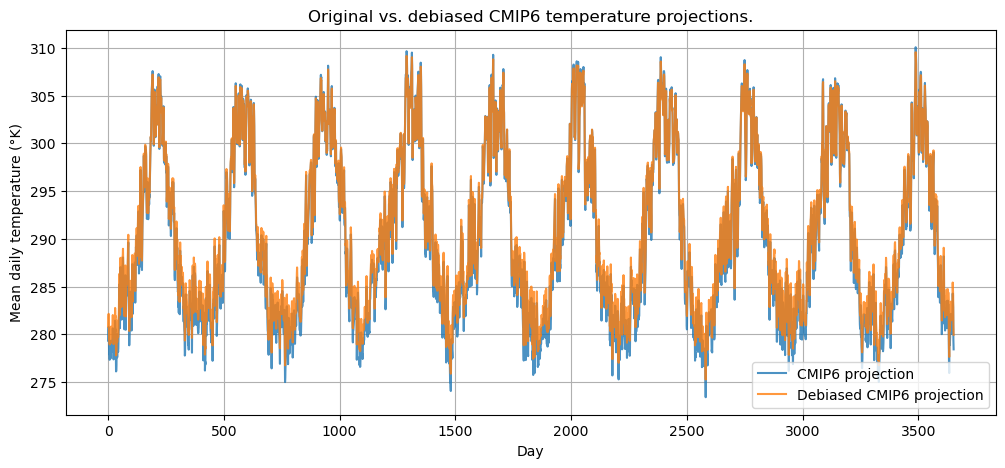

In [191]:
plt.figure(figsize=(12,5))
plt.title("Original vs. debiased CMIP6 temperature projections.")
plt.plot(cm_future_tmean[:, x_vis, y_vis], alpha=0.8, label="CMIP6 projection")
plt.plot(debiased_cm_future_tmean[:, x_vis, y_vis], alpha = 0.8, label="Debiased CMIP6 projection")
plt.xlabel("Day")
plt.ylabel("Mean daily temperature (°K)")
plt.legend()
plt.grid()
plt.show()

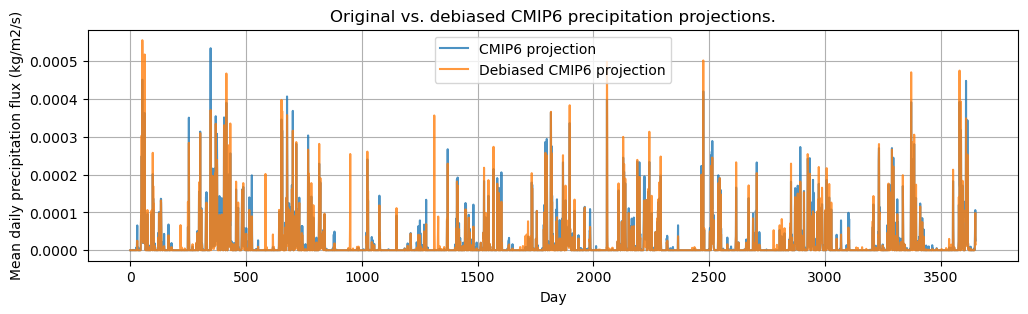

In [194]:
plt.figure(figsize=(12,3))
plt.title("Original vs. debiased CMIP6 precipitation projections.")
plt.plot(cm_future_prec[:, x_vis, y_vis], alpha=0.8, label="CMIP6 projection")
plt.plot(debiased_cm_future_prec[:, x_vis, y_vis], alpha = 0.8, label="Debiased CMIP6 projection")
plt.xlabel("Day")
plt.ylabel("Mean daily precipitation flux (kg/m2/s)")
plt.legend()
plt.grid()
plt.show()

# 4. Save debiased projection data

Now we can save the debiased climate projection values to a file, so we can use them for further analysis.

In [202]:
# Import the original temperature future projection dataset
future_ds_tmean = xr.open_mfdataset(future_model_tmean_path)
future_ds_tmin = xr.open_mfdataset(future_model_tmin_path)
future_ds_tmax = xr.open_mfdataset(future_model_tmax_path)
future_ds_prec = xr.open_mfdataset(future_model_prec_path)

future_ds = future_ds_tmean.copy()

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 3653, bnds: 2, lat: 12, lon: 16)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2040-01-01T12:00:00 ... 2049-12-31T...
  * lat        (lat) float64 96B 36.14 36.84 37.54 38.25 ... 42.46 43.16 43.86
  * lon        (lon) float64 128B -9.844 -9.141 -8.438 ... -0.7031 0.0 0.7031
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 58kB dask.array<chunksize=(3653, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 701kB dask.array<chunksize=(3653, 12, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 935kB dask.array<chunksize=(3653, 16, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 3MB dask.array<chunksize=(3653, 12, 16), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    tracking_id:            hdl:21.14100/c7a7929d-8ead-4a14-9803-174db7ca39fb
    variable_id:            tas
    variant_info:           forcing: Nat.Ant. Member generated from autosubmi...
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0

In [203]:
import dask
# Create a new variable, which is basically a duplicate of the existing variable,
# just for debiased values
tas_copy = future_ds_tmean['tas'].copy()
tasmin_copy = future_ds_tmin['tasmin'].copy()
tasmax_copy = future_ds_tmax['tasmax'].copy()
pr_copy = future_ds_prec['pr'].copy()

# Store the debiased values into these variables
# (in the same chunked dask array format)
tas_copy.data = dask.array.from_array(np.ma.masked_array(debiased_cm_future_tmean, mask = np.isnan(debiased_cm_future_tmean)), chunks=tas_copy.data.chunksize)
tasmin_copy.data = dask.array.from_array(np.ma.masked_array(debiased_cm_future_tmin, mask = np.isnan(debiased_cm_future_tmin)), chunks=tasmin_copy.data.chunksize)
tasmax_copy.data = dask.array.from_array(np.ma.masked_array(debiased_cm_future_tmax, mask = np.isnan(debiased_cm_future_tmax)), chunks=tasmax_copy.data.chunksize)
pr_copy.data = dask.array.from_array(np.ma.masked_array(debiased_cm_future_prec, mask = np.isnan(debiased_cm_future_prec)), chunks=pr_copy.data.chunksize)


# Add the new variables to the dataset
future_ds["tas_debiased"] = tas_copy
future_ds["tasmin_debiased"] = tasmin_copy
future_ds["tasmax_debiased"] = tasmax_copy
future_ds["pr_debiased"] = pr_copy

# Drop the original variables
future_ds = future_ds.drop_vars(["tas"])

# Show the new dataset
future_ds

<xarray.Dataset> Size: 13MB
Dimensions:          (time: 3653, bnds: 2, lat: 12, lon: 16)
Coordinates:
  * time             (time) datetime64[ns] 29kB 2040-01-01T12:00:00 ... 2049-...
  * lat              (lat) float64 96B 36.14 36.84 37.54 ... 42.46 43.16 43.86
  * lon              (lon) float64 128B -9.844 -9.141 -8.438 ... 0.0 0.7031
    height           float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds        (time, bnds) datetime64[ns] 58kB dask.array<chunksize=(3653, 2), meta=np.ndarray>
    lat_bnds         (time, lat, bnds) float64 701kB dask.array<chunksize=(3653, 12, 2), meta=np.ndarray>
    lon_bnds         (time, lon, bnds) float64 935kB dask.array<chunksize=(3653, 16, 2), meta=np.ndarray>
    tas_debiased     (time, lat, lon) float32 3MB dask.array<chunksize=(3653, 12, 16), meta=numpy.ma.MaskedArray>
    tasmin_debiased  (time, lat, lon) float32 3MB dask.array<chunksize=(3653, 12, 16), meta=numpy.ma.MaskedArray>
    tasmax_debiased  (time, lat, lon) float32 3MB dask.array<chunksize=(3653, 12, 16), meta=numpy.ma.MaskedArray>
    pr_debiased      (time, lat, lon) float32 3MB dask.array<chunksize=(3653, 12, 16), meta=numpy.ma.MaskedArray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    tracking_id:            hdl:21.14100/c7a7929d-8ead-4a14-9803-174db7ca39fb
    variable_id:            tas
    variant_info:           forcing: Nat.Ant. Member generated from autosubmi...
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0

In [206]:
# Save the dataset with the new debiased variables to file
future_ds.to_netcdf(parent_path / DEBIASED_FILENAME)